# Changes:
Reload saved model and troubleshoot low score

In [1]:
import zipfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
import math
import datetime as dt
import pytz

% matplotlib inline

In [2]:
def rle_encoder2d(x):
    if isinstance(x, torch.Tensor):
        x = x.detach().numpy()
    s = pd.Series(x.clip(0,1).flatten('F'))
    s.index = s.index+1
    df = s.to_frame('pred').assign(zero_cumcnt=s.eq(0).cumsum())
    df = df.loc[df.pred.gt(0)]
    df_rle = df.reset_index().groupby('zero_cumcnt').agg({'index': min, 'pred': sum}).astype(int).astype(str)
    rle = ' '.join((df_rle['index'] + ' '+df_rle['pred']).tolist())
    
    return rle

In [3]:
def rle_encoder3d(x):   
    return np.r_[[rle_encoder2d(e) for e in x]]

In [4]:
def load_img_to_df(img_path, normalize=False, mean_img=None, img_dtype=np.float):
    images = []
    for filename in glob.glob(f'{img_path}/*.png'): #assuming gif
        img_id = filename.split('\\')[-1].split('.')[0]
        img = np.array(imageio.imread(filename), dtype=img_dtype)
        if normalize:
            img -= mean_img[:,:,None]
        images.append([img_id, img])
    return pd.DataFrame(images, columns=['img_id', 'img']).set_index('img_id')

In [5]:
def load_img_to_np(img_path):
    images = []
    for filename in glob.glob(f'{img_path}/*.png'): #assuming gif
        img_id = filename.split('\\')[-1].split('.')[0]
        images.append(np.array(imageio.imread(filename), dtype=np.uint8))
    return np.r_[images]

In [6]:
def load_single_img(path, show=False):
    img = np.array(imageio.imread(path), dtype=np.uint8)
    if show:
        plt.imshow(img)
    return img

In [7]:
def format_train_data(X):
    X = np.moveaxis(X, -1,1)
    X = np.pad(X, [(0,0),(0,0),(0, 1), (0, 1)], mode='constant')
    return torch.from_numpy(X).float()

In [8]:
def get_train_batch(X_train, y_train, batch_size):
    batch_ids = np.random.choice(len(X_train), batch_size, replace=False)
    X_train_batch = X_train[batch_ids]
    X_train_batch = np.moveaxis(X_train_batch, -1,1)
    X_train_batch = np.pad(X_train_batch, [(0,0),(0,0),(0, 1), (0, 1)], mode='constant')
    y_train_batch = np.clip(y_train[batch_ids],0,1)
    
    return (torch.from_numpy(X_train_batch).float(), torch.from_numpy(y_train_batch).float())

In [138]:
def calc_raw_iou(a, b):
    if isinstance(a, torch.Tensor):
        a = a.detach().numpy()
    if isinstance(b, torch.Tensor):
        b = b.detach().numpy()
    a = np.clip(a, 0, 1)
    b = np.clip(b, 0, 1)
    u = np.sum(np.clip(a+b, 0, 1), (1,2)).astype(np.float)
    i = np.sum(np.where((a+b)==2, 1, 0), (1,2)).astype(np.float)
    with np.errstate(divide='ignore',invalid='ignore'):
        iou = np.where(i==u, 1, np.where(u==0, 0, i/u))
        
    return iou

In [131]:
def calc_mean_iou(a, b):
    thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
    iou = calc_raw_iou(a, b)
    iou_mean = (iou[:,None]>thresholds).mean(1).mean()

    return iou_mean

In [10]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [11]:
def get_current_time_as_fname():
        timestamp = (
                dt.datetime.now(pytz.timezone('Australia/Melbourne'))
                .strftime('%Y_%m_%d_%H_%M_%S')
                )
                
        return timestamp

In [12]:
def plot_img_mask_pred(image, mask, pred):
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[2].imshow(pred)
    axarr[0].grid()
    axarr[1].grid()
    axarr[2].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')
    axarr[2].set_title('Predicted Mask')

In [13]:
class SigToBinary(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, X):
        return X.ge(0.5)
    

In [14]:
class SaltNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(3,64,3, padding=10),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,128,3),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,256,3),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 2, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, X):
        out = self.seq(X)
        return torch.clamp(out[:,:,:-1,:-1].squeeze(), 0.0, 1.0)

In [15]:
def adjust_predictions(black_img_mean, zero_mask_cut_off, mean_img, X, y_pred, y=None):
    y_pred_adj = y_pred.clip(0,1)

    # Set predictions to all 0 for black images
    black_img_mask = ((X+mean_img[None,:,:,None]).mean((1,2,3))<black_img_mean)
    y_pred_adj[black_img_mask]=0

    # set all predictions to 0 if the number of positive predictions is less than ZERO_MASK_CUTOFF
    y_pred_adj = np.r_[[e if e.sum()>zero_mask_cut_off else np.zeros_like(e) for e in y_pred_adj]]
    
    if y is not None:
        print(f'IOU score before: {calc_iou(y_pred, y)}, IOU Score after:{calc_iou(y_pred_adj, y)}')
        
    return y_pred_adj

In [16]:
def show_img_grid():
    pass
    #plt.imshow(torchvision.utils.make_grid(torch.from_numpy(y_train_black).unsqueeze(1)).permute(1, 2, 0))

## Constant and Parameter Defination

In [17]:
BLACK_IMG_MEAN = 50
ZERO_MASK_CUTOFF = 120

## Load Data

In [20]:
mean_img = load_img_to_np('./data/train/images').mean((0,3))

df_train = load_img_to_df('./data/train/images', normalize=True, mean_img=mean_img)

df_train['mask'] = load_img_to_df('./data/train/masks/', img_dtype=np.uint8)['img']

In [21]:
df_test = load_img_to_df('./data/test/images', normalize=True, mean_img=mean_img)

In [22]:
X_test = np.r_[df_test.img.tolist()]

In [23]:
X_test.mean()

-0.6330799240815195

In [134]:
class IOU_Loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, y_pred, y):
        #print(y_pred.requires_grad)
        #y_pred = torch.where(y_pred.ge(0.5), torch.tensor(1.0), torch.tensor(0.0))
        i = y_pred.mul(y)
        u = (y_pred + y) - i
        mean_iou = torch.mean(i.view(i.shape[0],-1).sum(1) / u.view(i.shape[0],-1).sum(1))
        iou_loss = 1 - mean_iou
        #from boxx import g
        #g()
        
        return iou_loss

In [209]:
def calc_iou_loss(y_pred, y):
    
    u = torch.sum(torch.clamp(y+y_pred, 0.0, 1.0).view(y.shape[0],-1), 1).float()
    i = torch.sum(torch.where((y+y_pred)==2, torch.tensor(1.0), torch.tensor(0.0)).view(y.shape[0],-1), 1)
    #u.requires_grad = True
    #i.requires_grad = True
    iou = torch.where(i==u, torch.tensor(1.0), torch.where(u==0, torch.tensor(0.0), i/u))
    #iou.requires_grad = True
    mean_iou = torch.clamp(torch.mean(iou), 1e-10, torch.tensor(1.0))
    #mean_iou.requires_grad = True
    iou_loss = -torch.log(mean_iou)
    #iou_loss.requires_grad = True
    return iou_loss

## Train Val data split

In [43]:
X_train, X_val, y_train, y_val = (
    train_test_split(df_train, df_train['mask'], 
                     test_size=0.20, 
                     random_state=42)
)

In [47]:
X_train = np.r_[X_train.img.tolist()]

X_val = np.r_[X_val.img.tolist()]

y_train = np.r_[y_train.tolist()]

y_val = np.r_[y_val.tolist()]

## Create a Model

In [177]:
saltnet = SaltNet()

In [178]:
#loss_fn = nn.BCELoss()
loss_fn = IOU_Loss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)

In [179]:
start = time.time()

In [180]:
TRAIN_MODE = True

In [181]:
list(saltnet.parameters())[0].sum()

tensor(-1.0187)

In [161]:
list(saltnet.parameters())[-1].grad

In [162]:
#X_batch, y_batch = get_train_batch(X_train, y_train, batch_size=2)

In [182]:
if TRAIN_MODE:
    for iteration in range(1000):
        X_batch, y_batch = get_train_batch(X_train, y_train, batch_size=64)
        #y_pred = torch.tensor(saltnet(X_batch).ge(0.5).float(), requires_grad=True)
        y_pred = saltnet(X_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        if iteration % 20 == 0:
            iou_batch = calc_mean_iou(y_pred.ge(0.5), y_batch)
            print(f'Loss is {loss}, IOU is {iou_batch} at iter {iteration}, Time: {timeSince(start)}')
            


Loss is 0.8324899077415466, IOU is 0.059375000000000004 at iter 0, Time: 0m 22s
Loss is 0.7839808464050293, IOU is 0.196875 at iter 20, Time: 2m 32s
Loss is 0.6683609485626221, IOU is 0.290625 at iter 40, Time: 4m 49s
Loss is 0.6880804896354675, IOU is 0.21875000000000003 at iter 60, Time: 7m 52s
Loss is 0.6739736795425415, IOU is 0.240625 at iter 80, Time: 10m 46s
Loss is 0.7160935401916504, IOU is 0.20937499999999998 at iter 100, Time: 13m 15s
Loss is 0.6668895483016968, IOU is 0.24843749999999998 at iter 120, Time: 15m 38s
Loss is 0.7270203828811646, IOU is 0.19062500000000002 at iter 140, Time: 18m 12s
Loss is 0.5636687278747559, IOU is 0.3328125 at iter 160, Time: 20m 50s
Loss is 0.7488315105438232, IOU is 0.171875 at iter 180, Time: 23m 23s
Loss is 0.6358897089958191, IOU is 0.259375 at iter 200, Time: 28m 29s
Loss is 0.5746148228645325, IOU is 0.35000000000000003 at iter 220, Time: 34m 31s
Loss is 0.7160186767578125, IOU is 0.203125 at iter 240, Time: 40m 33s
Loss is 0.643581032

In [183]:
calc_mean_iou(y_pred.ge(0.5), y_batch)

0.40625

In [184]:
X_batch[1].shape

torch.Size([3, 102, 102])

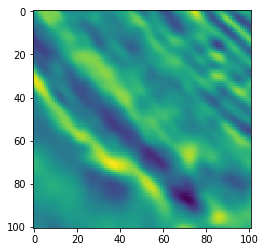

In [185]:
plt.imshow(X_batch[1][0].detach().numpy()[:101,:101]+mean_img)

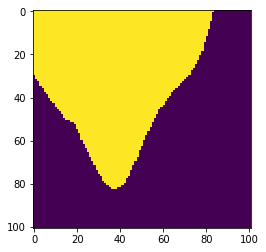

In [186]:
plt.imshow(y_batch[0])

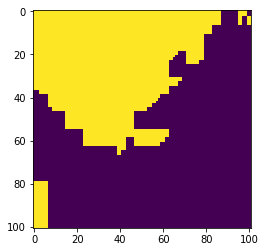

In [187]:
plt.imshow(y_pred.ge(0.5)[0])

In [126]:
y_pred_np = y_pred.ge(0.5).detach().numpy()

In [127]:
y_batch_np = y_batch.detach().numpy()

In [132]:
calc_raw_iou(y_pred_np, y_batch_np)

array([0.9992772 , 0.99713826])

In [133]:
calc_mean_iou(y_pred_np, y_batch_np)

1.0

In [112]:
y_batch.detach().numpy().shape

(2, 101, 101)

In [325]:
a = torch.rand(3,3, requires_grad=True)

In [326]:
a

tensor([[ 0.4054,  0.1794,  0.1386],
        [ 0.1540,  0.0732,  0.9761],
        [ 0.0375,  0.4661,  0.2143]])

In [327]:
b = torch.round(a)

In [328]:
b

tensor([[ 0.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  0.]])

In [329]:
torch.relu??

Docstring: <no docstring>
Type:      builtin_function_or_method


In [ ]:
if TRAIN_MODE:
    state = {'epoch': i + 1, 'state_dict': saltnet.state_dict(),
                 'optimizer': optimizer.state_dict() }
    ckp_name = f'saltnet_{get_current_time_as_fname()}.ckp'
    torch.save(state, ckp_name)

## Load checkpoint

In [34]:
state = torch.load('saltnet_v1_20180808_0837.cpt')

In [35]:
saltnet.load_state_dict(state['state_dict'])

### Set model to evaluation mode

In [189]:
saltnet.eval()

SaltNet(
  (seq): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(10, 10))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ConvTranspose

In [190]:
assert saltnet.training == False

### Make Predictions on validation set

In [191]:
X_val_torch = format_train_data(X_val)

In [192]:
with torch.no_grad():
    y_val_pred = saltnet(X_val_torch)

y_val_pred = y_val_pred.ge(0.5).detach().numpy()

612
552
681


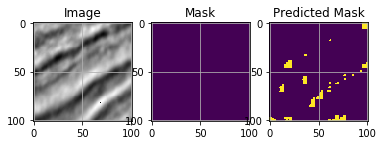

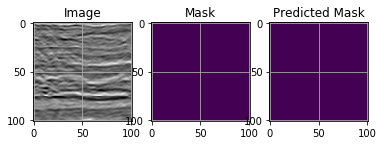

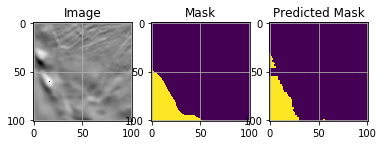

In [202]:
for i in range(3):
    rand_id = np.random.choice(len(X_val))
    print(rand_id)
    val_img = X_val[rand_id] + mean_img[:,:,None]
    val_mask = y_val[rand_id]
    val_mask_pred = y_val_pred[rand_id]
    plot_img_mask_pred(val_img, val_mask, val_mask_pred)

In [194]:
y_val_pred = adjust_predictions(BLACK_IMG_MEAN, ZERO_MASK_CUTOFF, mean_img, X_val, y_val_pred, y_val)

IOU score before: 0.32862500000000006, IOU Score after:0.43250000000000005


## Make predictions on test set

In [50]:
y_test_pred_raw = []

In [51]:
for x in np.split(X_test, 36):
    with torch.no_grad():
        y_test_pred_raw.append(saltnet(format_train_data(x)))

In [52]:
y_test_pred_raw = torch.cat(y_test_pred_raw)

In [53]:
y_test_pred = y_test_pred_raw.ge(0.5).detach().numpy()

### Show segmentation masks for a few images

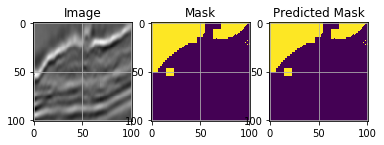

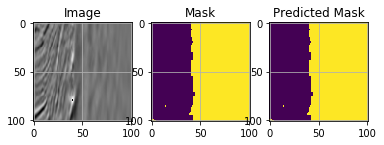

In [84]:
for i in range(2):
    rand_id = np.random.choice(len(X_test))
    #print(rand_id)
    img = X_test[rand_id] + mean_img[:,:,None]
    #mask = y_train[rand_id]
    mask_pred = y_test_pred[rand_id]
    plot_img_mask_pred(img, mask_pred, mask_pred)

### Adjust predictions

In [55]:
y_test_pred = adjust_predictions(BLACK_IMG_MEAN, ZERO_MASK_CUTOFF, mean_img, X_test, y_test_pred)

### Encode predictions using RLE(Run Length Encoding) method

In [56]:
y_test_pred_rle = rle_encoder3d(y_test_pred)

In [57]:
df_test_rle = pd.DataFrame(index=df_test.index, data=y_test_pred_rle).reset_index()

In [58]:
df_test_rle.columns = ['id', 'rle_mask']

In [59]:
df_test_rle[df_test_rle.rle_mask==''].shape

(6665, 2)

In [60]:
df_test_rle.to_csv(f'submission_{get_current_time_as_fname()}.csv', index=False)